In [37]:
import pandas as pd
import numpy as np
import torch.nn.functional as F
from copy import deepcopy
import warnings
warnings.simplefilter('ignore')
import torchviz
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import joblib
import os
from sklearn.preprocessing import StandardScaler
import time
def get_col(df,name):
    return df.columns[df.columns.str.contains(name)].tolist()
os.listdir('../data')

['dataset.pkl', 'tag_cleaned.csv']

# load data

In [38]:
tag = pd.read_csv('../data/tag_cleaned.csv',index_col=0)
tag = tag.loc[tag.category=='可控制因子']

In [39]:
data = joblib.load('../data/dataset.pkl')
data.keys()

dict_keys(['state', 'action', 'output', 'stream', 'idx', 'mm_state', 'mm_action', 'mm_output', 'mm_stream', 'state_col', 'action_col', 'output_col', 'stream_col'])

In [63]:
data['action_col']

['MLPAP_FQ-0619.PV',
 'MLPAP_TJC-0627.PV',
 'MLPAP_TRC-0610.PV',
 'MLPAP_FR-0632.PV',
 'MLPAP_TJC-0757A.PV',
 'MLPAP_PIC-0761.PV',
 'MLPAP_TJC-1721.PV',
 'MLPAP_TRC-1734.PV',
 'MLPAP_TRC-0747.PV',
 'MLPAP_TJ-0881.PV',
 'MLPAP_TJ-0757B.PV',
 '濃度']

# tensor data

In [40]:
n = 0 
state = torch.FloatTensor(data['state'][n:]).cuda()
action = torch.FloatTensor(data['action'][n:]).cuda()
output = torch.FloatTensor(data['output'][n:]).cuda()
stream = torch.FloatTensor(data['stream'][n:]).cuda()

# split data

In [41]:
#test_df = pd.read_csv('../data/反應槽(20200201-20200212)開車資料.csv',
#                 index_col=0,
#                 parse_dates=True,
#                 encoding='latin-1')
#test_df = test_df.dropna(axis=0)
#print(test_df.shape)

In [42]:
sp1 = int(len(state)*0.8)
sp2 = int(len(state)*0.9)
print(sp1,sp2)

47370 53291


# data_iter

In [43]:
train = torch.utils.data.TensorDataset(state[:sp1],action[:sp1],output[:sp1],stream[:sp1])
valid = torch.utils.data.TensorDataset(state[sp2:],action[sp2:],output[sp2:],stream[sp2:])
test = torch.utils.data.TensorDataset(state[sp2:],action[sp2:],output[sp2:],stream[sp2:])

train_iter = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valid_iter = torch.utils.data.DataLoader(valid, batch_size=128, shuffle=True)

In [44]:
print(action.shape)
time_step = action.shape[1]
num_sensor = action.shape[2]

torch.Size([59213, 36, 12])


# Construct the neural network

In [45]:
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.time_step = time_step
        self.num_sensor = num_sensor
        self.h_size = 128
        
        self.output_layer = nn.Sequential(nn.Linear(self.h_size,self.h_size),
                                          nn.ReLU(),
                                          nn.Dropout(0.2),
                                          nn.Linear(self.h_size,1),
                                         )
        
        self.stream_layer = nn.Sequential(nn.Linear(self.h_size,self.h_size),
                                          nn.ReLU(),
                                          nn.Linear(self.h_size,1),
                                         )
        
        self.conv_layer = nn.Sequential(nn.Conv1d(self.num_sensor,self.h_size-1,kernel_size = 36),
                                        nn.ReLU(),
                                       )
        
        self.fc_layer = nn.Sequential(nn.Linear(self.h_size+1,self.h_size),
                                          nn.ReLU(),
                                          nn.Linear(self.h_size,self.h_size),
                                         )
        
    def forward(self,state,action):
        batch_size = state.shape[0]
        
        # action
        action = self.conv_layer(action.permute(0,2,1)).reshape(batch_size,-1)
        
        # combine state action
        combine = torch.cat((state,action),dim=-1)
        
        # fc forward
        combine = self.fc_layer(combine)
        
        # get output and stream
        output = self.output_layer(combine)
        stream = self.stream_layer(combine)
        
        return F.sigmoid(output),F.sigmoid(stream)

In [46]:
def init_weights(m):
    if hasattr(m,'weight'):
        try:
            torch.nn.init.xavier_uniform(m.weight)
        except:
            pass
    
    if hasattr(m,'bias'):
        try:
            m.bias.data.fill_(0.1)
        except:
            pass

In [47]:
net = Critic().cuda()
net.apply(init_weights)

Critic(
  (output_layer): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
  (stream_layer): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (conv_layer): Sequential(
    (0): Conv1d(12, 127, kernel_size=(36,), stride=(1,))
    (1): ReLU()
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=129, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
)

# forward test

In [48]:
a,b = net(state,action)
print(a.shape)
print(b.shape)

torch.Size([59213, 1])
torch.Size([59213, 1])


# tensorboard

In [49]:
with SummaryWriter(comment='Net')as w:
    w.add_graph(net, (test.tensors[0:2]))

# loss and opt

In [50]:
optimizer = torch.optim.Adam(net.parameters(),lr=1e-3)

In [51]:
from torch.nn import L1Loss

l1loss = L1Loss()
def loss_function(output,stream,target_output,target_stream):
    loss = l1loss(output,target_output)
    return loss.mean()    

# train and eval

In [52]:
def train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = np.inf
    best_net = None
    for epoch in range(num_epochs): 
        
        # train model
        net.train()
        train_loss,i = 0,0
        for state,action,output,stream in train_iter:
            output_pred,stream_pred = net(state,action)
            loss = loss_function(output_pred,stream_pred,output,stream)
            train_loss += loss.item()
            i += 1
            
            # update model
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # eval model (afater update model)
        with torch.no_grad():
            net.eval()
            val_loss,j = 0,0
            for state,action,output,stream in valid_iter:
                output_pred,stream_pred = net(state,action)
                loss = loss_function(output_pred,stream_pred,output,stream)
                val_loss += loss.item()
                j += 1
        
        # caculate avg_loss
        train_avg_loss = train_loss/i
        val_avg_loss = val_loss/j
        
        # save the best_model
        if val_avg_loss <= best_loss:
            best_loss = val_avg_loss
            best_net = deepcopy(net) #backup the model(deepcopy)
            print('model recorded!')
        
        # record history and print loss of the epoch
        train_history.append(train_avg_loss)
        valid_history.append(val_avg_loss)
        print("epochs {} train_avg_loss {:.4f} valid_avg_loss {:.4f}".format(
            epoch,train_avg_loss,val_avg_loss))
        
    # plot result
    print('best val_avg_loss is ',best_loss)
    
    fig = plt.figure(figsize=(20,5))
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.legend()
    plt.title('loss')
    plt.show()
    
    return best_net.eval()

model recorded!
epochs 0 train_avg_loss 0.0274 valid_avg_loss 0.0189
epochs 1 train_avg_loss 0.0181 valid_avg_loss 0.0413
epochs 2 train_avg_loss 0.0166 valid_avg_loss 0.0577
epochs 3 train_avg_loss 0.0159 valid_avg_loss 0.0539
model recorded!
epochs 4 train_avg_loss 0.0155 valid_avg_loss 0.0133
epochs 5 train_avg_loss 0.0148 valid_avg_loss 0.0170
epochs 6 train_avg_loss 0.0142 valid_avg_loss 0.0152
model recorded!
epochs 7 train_avg_loss 0.0143 valid_avg_loss 0.0118
epochs 8 train_avg_loss 0.0139 valid_avg_loss 0.0189
epochs 9 train_avg_loss 0.0138 valid_avg_loss 0.0126
model recorded!
epochs 10 train_avg_loss 0.0135 valid_avg_loss 0.0089
epochs 11 train_avg_loss 0.0137 valid_avg_loss 0.0096
epochs 12 train_avg_loss 0.0131 valid_avg_loss 0.0360
epochs 13 train_avg_loss 0.0130 valid_avg_loss 0.0389
epochs 14 train_avg_loss 0.0133 valid_avg_loss 0.0125
epochs 15 train_avg_loss 0.0128 valid_avg_loss 0.0285
epochs 16 train_avg_loss 0.0125 valid_avg_loss 0.0091
epochs 17 train_avg_loss 0.0

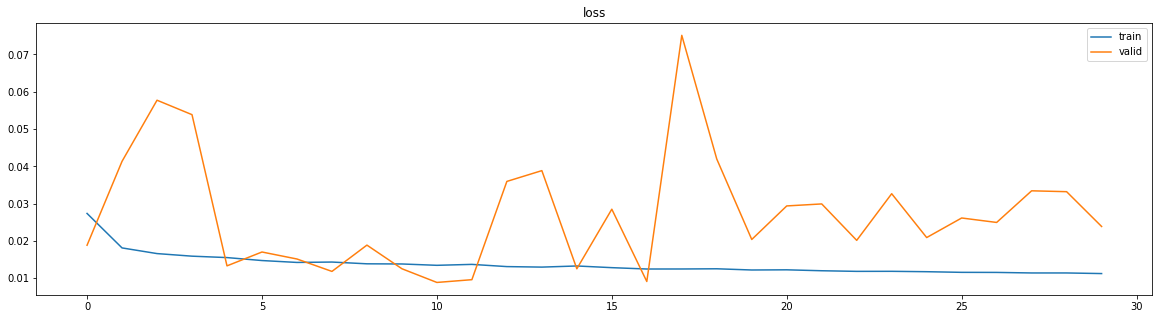

In [53]:
net = train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=30)

# make prediction

In [54]:
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt

def mape(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()*100

In [55]:
def make_prediction(state,action,output,streamn):
    
    y_pred = net(state,action)[0].detach().cpu().numpy()
    y_pred = data['mm_output'].inverse_transform(y_pred).ravel()
    
    y_pred2 = net(state,action)[1].detach().cpu().numpy()
    y_pred2 = data['mm_stream'].inverse_transform(y_pred2)
    
    y_real = output.detach().cpu().numpy()
    y_real = data['mm_output'].inverse_transform(y_real).ravel()
    
    y_real2 = stream.detach().cpu().numpy()
    y_real2 = data['mm_stream'].inverse_transform(y_real2)
    
    feed = action.detach().cpu().numpy()
    temp = [data['mm_action'].inverse_transform(feed[i]) for i in range(len(feed))]
    feed = np.array(temp)[:,:,0][:,0]
    
    table = pd.DataFrame()
    table['0619'] = feed
    table['0997_real'] = y_real
    table['0997_pred'] = y_pred
    table['真實單耗'] = feed/y_real
    table['預測單耗'] = feed/y_pred
    table['真實蒸氣'] = y_real2
    table['預測蒸氣'] = y_pred2
    
    return table

In [56]:
def make_metric(table):
    
    metric = pd.DataFrame(index=[0],columns=['R2(出料)','RMSE(單耗)','MAPE(單耗)'])
    metric['R2(出料)'] = r2_score(table['0997_real'],table['0997_pred'])
    metric['RMSE(單耗)'] = sqrt(mean_squared_error(table['真實單耗'],table['預測單耗']))
    metric['MAPE(單耗)'] = mape(table['真實單耗'],table['預測單耗'])
    metric.index.name = '出料'
    
    metric2 = pd.DataFrame(index=[0],columns=['R2','RMSE','MAPE'])
    metric2['R2'] = r2_score(table['真實蒸氣'],table['預測蒸氣'])
    metric2['RMSE'] = sqrt(mean_squared_error(table['真實蒸氣'],table['預測蒸氣']))
    metric2['MAPE'] = mape(table['真實蒸氣'],table['預測蒸氣'])
    metric2.index.name = '蒸氣'
    
    return metric,metric2

# train metric

In [57]:
state ,action, output, stream = train_iter.dataset.tensors
table = make_prediction(state,action,output,stream)
metric,metric2 = make_metric(table)
metric

,R2(出料),RMSE(單耗),MAPE(單耗)
出料,,,
0,0.966661,0.014325,0.924231


In [58]:
metric2

,R2,RMSE,MAPE
蒸氣,,,
0,-6.319597,11964.027416,24.682905


# test metric

In [59]:
state ,action, output, stream = test.tensors
table = make_prediction(state,action,output,stream)
metric,metric2 = make_metric(table)
metric

,R2(出料),RMSE(單耗),MAPE(單耗)
出料,,,
0,0.964821,0.010704,0.798767


In [60]:
metric2

,R2,RMSE,MAPE
蒸氣,,,
0,-3.350693,4864.19058,10.747481


# save 

In [61]:
joblib.dump(net,'../model/Critic.pkl')
print('save done!')

save done!
